In [25]:
!pip install livelossplot
from livelossplot import PlotLosses
import pandas as pd
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset


In [26]:
using_collab = True

In [27]:

BATCH_SIZE = 3
WINDOW_SIZE = 5

In [28]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ## uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

set_seed(42)

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# The following 3 cells speed up I/O. They are vital for google collab usage.
# Comment if you are not using collab

# Load the initial data

# Copy the file from Google Drive to the local Colab environment
!cp "/content/drive/MyDrive/Selected_Storms_curated.tgz" "/content/"

# Extract the contents of the tar.gz file
!tar -xvzf '/content/Selected_Storms_curated.tgz' -C "/content/"

# List the contents to confirm it's been extracted
!ls /content/

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
Selected_Storms_curated_to_zip/wsy/wsy_083.jpg
Selected_Storms_curated_to_zip/wsy/._wsy_297_features.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
Selected_Storms_curated_to_zip/wsy/wsy_297_features.json
Selected_Storms_curated_to_zip/wsy/._wsy_310_label.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
Selected_Storms_curated_to_zip/wsy/wsy_310_label.json
Selected_Storms_curated_to_zip/wsy/._wsy_068.jpg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header

In [31]:
# Load the Surprise storm

!cp "/content/drive/MyDrive/Surprise_Storm.tgz" "/content/"
!tar -xvzf '/content/Surprise_Storm.tgz' -C "/content/"
!ls /content/

Surprise_Storm/
Surprise_Storm/tst/
Surprise_Storm/tst/tst_048.jpg
Surprise_Storm/tst/tst_232_features.json
Surprise_Storm/tst/tst_083_label.json
Surprise_Storm/tst/tst_162_label.json
Surprise_Storm/tst/tst_211_label.json
Surprise_Storm/tst/tst_032_label.json
Surprise_Storm/tst/tst_097_features.json
Surprise_Storm/tst/tst_247_features.json
Surprise_Storm/tst/tst_096_features.json
Surprise_Storm/tst/tst_233.jpg
Surprise_Storm/tst/tst_244_features.json
Surprise_Storm/tst/tst_140.jpg
Surprise_Storm/tst/tst_138.jpg
Surprise_Storm/tst/tst_107_features.json
Surprise_Storm/tst/tst_165.jpg
Surprise_Storm/tst/tst_179_features.json
Surprise_Storm/tst/tst_177.jpg
Surprise_Storm/tst/tst_203_label.json
Surprise_Storm/tst/tst_097_label.json
Surprise_Storm/tst/tst_013_label.json
Surprise_Storm/tst/tst_213_label.json
Surprise_Storm/tst/tst_071.jpg
Surprise_Storm/tst/tst_164_features.json
Surprise_Storm/tst/tst_125_features.json
Surprise_Storm/tst/tst_081_label.json
Surprise_Storm/tst/tst_126_label.jso

In [32]:
# Load the interpolated data

# !cp "/content/drive/MyDrive/interpolation.tar.gz" "/content/"
# !tar -xvzf '/content/interpolation.tar.gz' -C "/content/"
# !ls /content/

In [33]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the file from Google Drive to the local Colab environment
!cp "/content/drive/MyDrive/Surprise_Storm.tgz" "/content/"

# Extract the contents of the tar.gz file
!tar -xvzf '/content/Surprise_Storm.tgz' -C "/content/"

# List the contents to confirm it's been extracted
!ls /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Surprise_Storm/
Surprise_Storm/tst/
Surprise_Storm/tst/tst_048.jpg
Surprise_Storm/tst/tst_232_features.json
Surprise_Storm/tst/tst_083_label.json
Surprise_Storm/tst/tst_162_label.json
Surprise_Storm/tst/tst_211_label.json
Surprise_Storm/tst/tst_032_label.json
Surprise_Storm/tst/tst_097_features.json
Surprise_Storm/tst/tst_247_features.json
Surprise_Storm/tst/tst_096_features.json
Surprise_Storm/tst/tst_233.jpg
Surprise_Storm/tst/tst_244_features.json
Surprise_Storm/tst/tst_140.jpg
Surprise_Storm/tst/tst_138.jpg
Surprise_Storm/tst/tst_107_features.json
Surprise_Storm/tst/tst_165.jpg
Surprise_Storm/tst/tst_179_features.json
Surprise_Storm/tst/tst_177.jpg
Surprise_Storm/tst/tst_203_label.json
Surprise_Storm/tst/tst_097_label.json
Surprise_Storm/tst/tst_013_label.json
Surprise_Storm/tst/tst_213_label.json
Surprise_Storm/tst/tst_071.jpg
Surprise_Storm/tst/tst_164_

In [34]:
import os
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class DATDataset(Dataset):
    def __init__(self, n, image_transforms=None, data=None):
        self.n = n  # Number of sequential images to consider
        self.image_transforms = image_transforms
        self.storms_data = {}

        if data == None:
            directory = f"/content/Selected_Storms_curated_to_zip"

        elif data == "surprise":
            directory = f"/content/Surprise_Storm"

        else:
            directory = f"/content/interpolation"

        # Organize data by storm
        for subdir, dirs, files in os.walk(directory):
            storm_name = os.path.basename(subdir)
            storm_files = [f for f in files if f.endswith(".jpg") and not f.startswith(".")]
            storm_files.sort()  # Ensure the files are sorted

            # Create a list of tuples for each storm
            self.storms_data[storm_name] = [
                os.path.join(subdir, f) for f in storm_files
            ]

        # Flatten the data for easier indexing
        self.flattened_data = []
        for storm, files in self.storms_data.items():
            for i in range(len(files) - n):
                self.flattened_data.append((files[i:i + n], files[i + n]))

    def __getitem__(self, index):
        sequential_data, next_data = self.flattened_data[index]

        def load_data(data_point):
            image_path = data_point
            image = Image.open(image_path)
            image_array = np.array(image)

            if self.image_transforms:
                image_array = self.image_transforms(image_array)

            return image_array

        # Load N sequential data
        sequential_loaded = [load_data(dp) for dp in sequential_data]

        # Load N+1th data
        next_loaded = load_data(next_data)

        return sequential_loaded, next_loaded

    def __len__(self) -> int:
        return len(self.flattened_data)

def normalize_image(image):
  return (image - image.min()) / (image.max() - image.min())

image_dimension = 224
transforms_for_array = v2.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_dimension, image_dimension)),
    transforms.Grayscale(num_output_channels=1),
    # transforms.Lambda(lambda x: normalize_image(x))

    ])

data = DATDataset(n=5, image_transforms=transforms_for_array, data="surprise")
full_data = DATDataset(n=5, image_transforms=transforms_for_array)
interpolation_data = DATDataset(n=5, image_transforms=transforms_for_array, data="interpolation")


# Final model : Convolutional and Bidirectional LSTM Network with Adaptive Pooling

The enhanced CNNLSTM network incorporates several modifications over the baseline model to improve its performance. We have added in this network:

* Increased LSTM Hidden Size: It was increased from 128 to 256, providing the LSTM layer with more capacity to learn complex patterns in the data.
* Additional Convolutional Layer: An extra convolutional layer (denoted as conv3) was added, increasing the depth of the CNN part of the network to capture more complex features from the input images.
* Increased Channels in Convolutional Layers: The number of channels in the convolutional layers increases progressively to extract a more rich set of features at different levels.
* Batch Normalization and LeakyReLU Activation: Each convolutional layer is followed by a batch normalization layer  and a LeakyReLU activation, improving the network's stability and ability to generalize.
* Adaptive Pooling: This allows for more flexible handling of the input dimensions.
* Bidirectional LSTM: This enables to process data in both forward and reverse directions to improve the learning of temporal dependencies.
* Dropout Regularization: Introduces regularization to the network to prevent overfitting.

These enhancements improve the network's ability to learn the distribution of the data. It manages to produce higher quality images and learn the evolution between successive timesteps.

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## network with more layers

#100 epochs batch 3

class CNNLSTM_final(nn.Module):
    def __init__(self, reduced_dimension=4, image_dimension=8, lstm_layers=2, lstm_hidden_size=256, dropout_rate=0.5):
        super(CNNLSTM_final, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size  # Increased hidden size
        self.conv_channels = 16  # You can also increase this for more capacity

        # CNN part with added layers and increased channels
        self.conv1 = nn.Conv2d(1, self.conv_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv_channels)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(self.conv_channels, self.conv_channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv_channels * 2)
        self.relu2 = nn.LeakyReLU()
        # Adding one more convolutional layer
        self.conv3 = nn.Conv2d(self.conv_channels * 2, self.conv_channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv_channels * 4)
        self.relu3 = nn.LeakyReLU()

        self.dropout = nn.Dropout(dropout_rate)

        # Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(reduced_dimension, reduced_dimension))

        # LSTM part with increased capacity
        self.lstm = nn.LSTM(
            input_size=self.conv_channels * 4 * reduced_dimension * reduced_dimension,  # Adjusted for the increased channels
            hidden_size=self.lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout_rate if lstm_layers > 1 else 0,
            bidirectional=True
        )

        # Fully connected part
        self.fc = nn.Linear(self.lstm_hidden_size * 2, 1 * image_dimension * image_dimension)  # Adjusted for the output size
        self.reshape = lambda x: x.view(-1, 1, image_dimension, image_dimension)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()

        # Apply CNN to each image in the sequence
        cnn_out = []
        for t in range(seq_len):
            out = self.conv1(x[:, t, :, :, :])
            out = self.bn1(out)
            out = self.relu1(out)
            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu2(out)
            out = self.conv3(out)  # Pass through an additional conv layer
            out = self.bn3(out)
            out = self.relu3(out)
            out = self.dropout(out)
            out = self.avg_pool(out)
            out = out.view(out.size(0), -1)
            cnn_out.append(out)

        # Convert list to tensor
        cnn_out = torch.stack(cnn_out, dim=1)

        # LSTM part
        lstm_out, _ = self.lstm(cnn_out)

        # Reconstruct the image
        out = self.fc(lstm_out[:, -1, :])
        out = self.reshape(out)

        return out

# Create the model with increased dimensions
model = CNNLSTM_final(image_dimension=224)  # Adjust image_dimension to match your target output size


In [36]:
BATCH_SIZE = 3


In [37]:
train_loader = torch.utils.data.DataLoader(
        data,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

In [38]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    model.to(device)
    train_loss, train_accuracy = 0, 0
    for window, final_frame in data_loader:
        window = torch.hstack(window)
        window = window.unsqueeze(2)
        window, final_frame = window.to(device), final_frame.to(device)

        optimizer.zero_grad()
        outputs = model(window)

        loss = criterion(outputs, final_frame)
        loss.backward()
        train_loss += loss*final_frame.size(0)
        optimizer.step()

    # loss, acc
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

In [ ]:
def train_model(model, train_loader, val_loader, epochs, model_params=None):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    criterion = nn.MSELoss()

    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        train_loss, train_accuracy = train(
            model = model,
            criterion = criterion,
            optimizer = optimizer,
            data_loader=train_loader
        )

        logs['' + 'log loss'] = train_loss.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

model = train_model(model=model,
                    train_loader=train_loader,
                    val_loader=train_loader,
                    epochs=100)

In [40]:
# Get the surprise data
sample_batch = next(iter(train_loader))
window_batch, final_frame_batch = sample_batch
window_batch = torch.hstack(window_batch)
window_batch = window_batch.unsqueeze(2)


torch.Size([224, 224])
torch.Size([224, 224])
torch.Size([224, 224])


Text(0.5, 1.0, 'Display the images in a sequence sequentially')

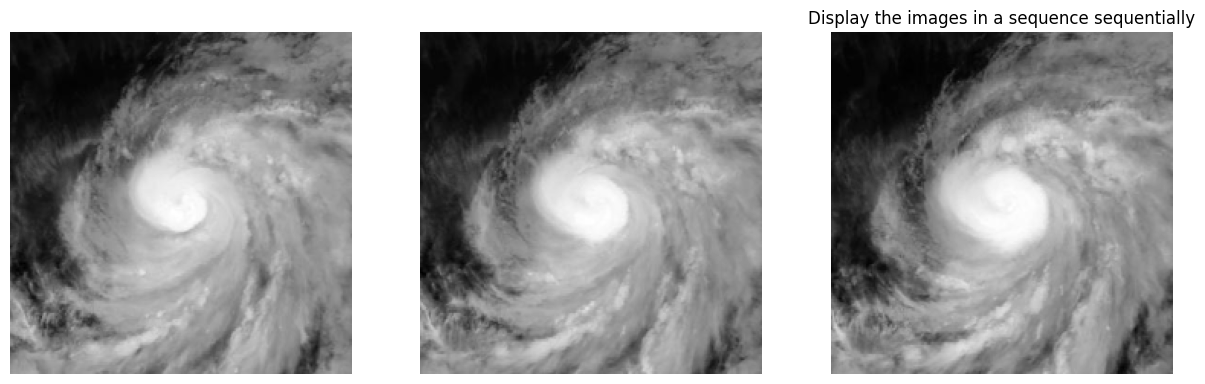

In [41]:
# Ensure that our batches work properly.
# Display the images in a window sequentially
fig, ax = plt.subplots(1,len(window_batch), figsize=(15,15))
image_to_show = 0
for i in range(len(window_batch)):
    print(window_batch[image_to_show][i].squeeze().shape)
    ax[i].imshow(window_batch[image_to_show][i].squeeze(), cmap="gray")
    ax[i].axis('off')

plt.title("Display the images in a sequence sequentially")


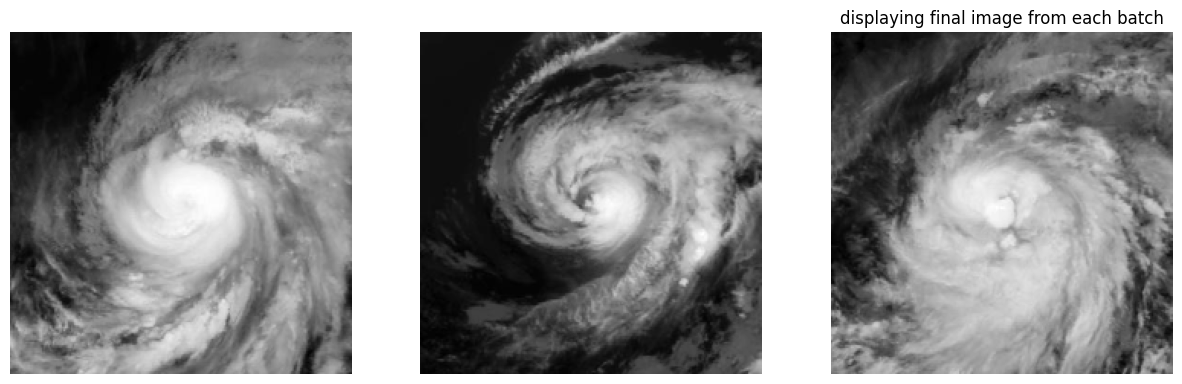

In [42]:
# displaying final image from each batch
fig, ax = plt.subplots(1, len(window_batch), figsize=(15,15))
plt.title("displaying final image from each batch")

for i in range(len(window_batch)):
    ax[i].imshow(window_batch[i][-1].squeeze(), cmap="gray")
    ax[i].axis('off')

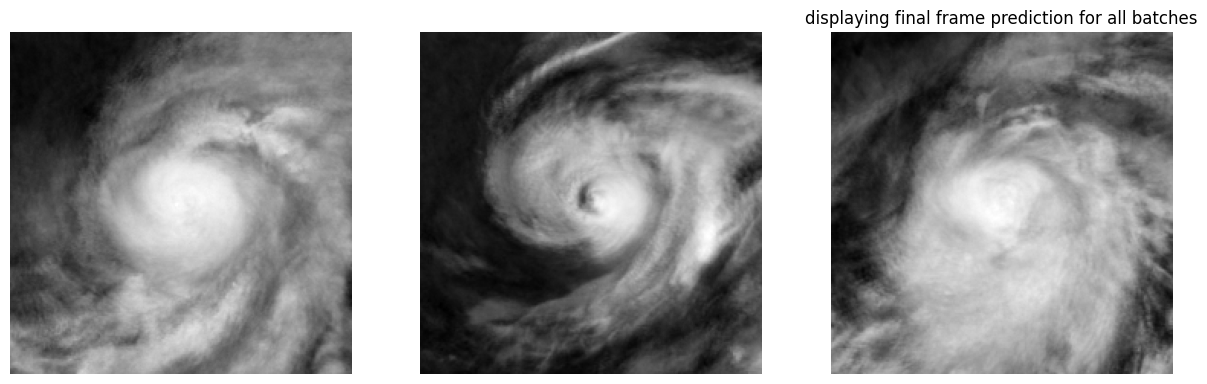

In [43]:
# displaying final frame prediction for all batches
predictions = model(window_batch.cuda())
fig, ax = plt.subplots(1,len(predictions), figsize=(15,15))

plt.title("displaying final frame prediction for all batches")
for i in range(len(predictions)):
    ax[i].imshow(predictions[i].squeeze().detach().cpu().numpy(), cmap="gray")
    ax[i].axis('off')

torch.Size([1, 3, 1, 224, 224])


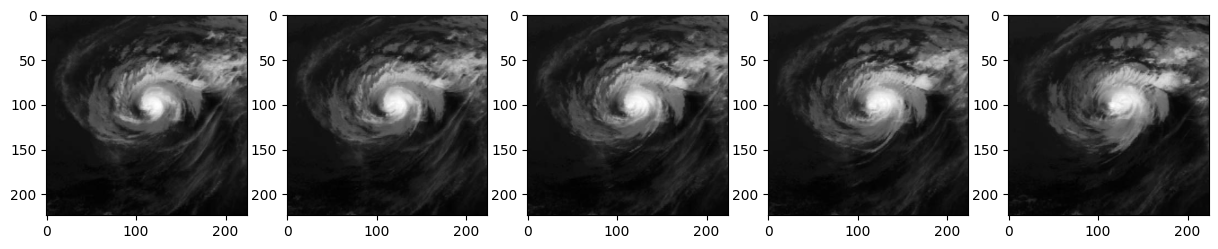

In [44]:
storm_loader = torch.utils.data.DataLoader(
        data,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

fig, ax = plt.subplots(1, WINDOW_SIZE, figsize=(15,15))

predicted_images = []
for window, _ in storm_loader:
    # batch shape is: batch_size, window_size, width, height
    final_batch = torch.hstack(window)

# Get the final window from your batches
final_window = final_batch[-1]

for i in range(len(final_batch[-1])):
    ax[i].imshow(final_batch[-1][i].squeeze(), cmap="gray")

# get the final window in the correct shape
reshaped_final_window = final_window.to(device).unsqueeze(0).unsqueeze(2)

# This loop was written in part with the help of chat-gpt
# https://chat.openai.com/share/ecbb7f31-eace-4947-add9-9b059c7b3674

for i in range(3):

    # predict the next image
    next_image = model(reshaped_final_window.to(device)).to(device).unsqueeze(0)

    # add the predicted image to our list of images
    predicted_images.append(next_image)

    # Remove the first image from the window
    final_window_one_frame_down = reshaped_final_window[0][1:].unsqueeze(0)

    # Add the next image to the end of the window
    new_window = torch.cat((final_window_one_frame_down, next_image[:, :1, :, :, :]), dim=1)

    reshaped_final_window = new_window

    # next_image = model(new_window)

print(torch.hstack(predicted_images).shape)

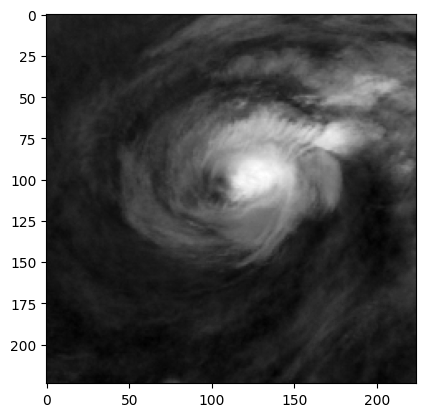

In [45]:
plt.imshow(torch.hstack(predicted_images)[0][0].squeeze().cpu().detach().numpy(), cmap = "gray")

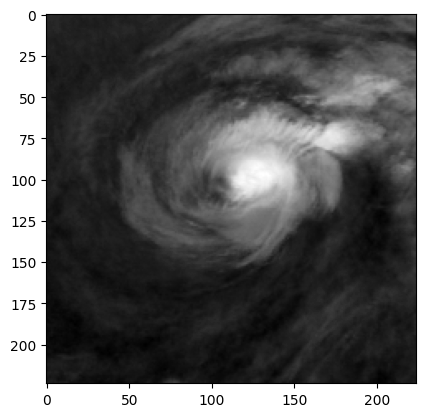

In [46]:
plt.imshow(torch.hstack(predicted_images)[0][1].squeeze().cpu().detach().numpy(),cmap = "gray" )

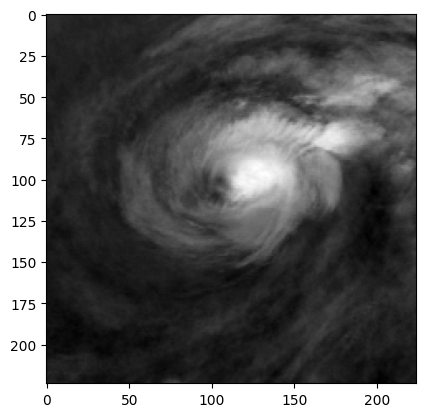

In [47]:
plt.imshow(torch.hstack(predicted_images)[0][2].squeeze().cpu().detach().numpy(),cmap = "gray")

In [48]:

save_images = False

if save_images:
    torch.hstack(predicted_images)[0].squeeze().shape
    predictions_array = [i for i in torch.hstack(predicted_images)[0].squeeze()]

    for i in range(len(predictions_array)):
        image = Image.fromarray((predictions_array[i] * 255).detach().cpu().numpy().astype(np.uint8))
        image.save(f'prediction{i}.jpg')
